In [1]:
!pip install keras
!pip install adversarial-robustness-toolbox
!pip install foolbox

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras.backend as K
from keras.models import  load_model
import tensorflow as tf
from keras.layers import Input, Reshape, Add
from keras import backend as K
from keras.layers.noise import GaussianNoise
import numpy as np
from functools import reduce
from operator import mul
from keras.models import Model
from keras import metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint
import foolbox
import keras
import numpy as np
from random import randint



Using TensorFlow backend.


In [3]:
def plot_attack(image, adversarial):
    # if you use Jupyter notebooks
    %matplotlib inline

    import matplotlib.pyplot as plt

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(image.reshape((28, 28)), cmap='gray')  # division by 255 to convert [0, 255] to [0, 1]
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial.reshape((28, 28)), cmap='gray')  # ::-1 to convert BGR to RGB
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial- image
    print(np.max(difference))
    plt.imshow((difference + 0.5).reshape((28, 28)), cmap='gray')
    plt.axis('off')

    plt.show()
    

In [4]:
batch_size = 128
num_classes = 10
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [5]:
epochs = 4

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 14s 231us/step - loss: 0.1913 - acc: 0.9411 - val_loss: 0.0569 - val_acc: 0.9823
Epoch 2/4
60000/60000 [==============================] - 12s 195us/step - loss: 0.0510 - acc: 0.9846 - val_loss: 0.0450 - val_acc: 0.9854
Epoch 3/4
60000/60000 [==============================] - 11s 191us/step - loss: 0.0310 - acc: 0.9904 - val_loss: 0.0355 - val_acc: 0.9878
Epoch 4/4
60000/60000 [==============================] - 11s 188us/step - loss: 0.0198 - acc: 0.9943 - val_loss: 0.0447 - val_acc: 0.9848
Test loss: 0.044733963569859043
Test accuracy: 0.9848


In [6]:
from keras.models import save_model
save_model(model, 'mnist_model.h5')

In [7]:
K.clear_session()
inference_model = load_model('mnist_model.h5')
for l in inference_model.layers:
    l.trainable = False

In [8]:
score = inference_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.044733963569859043
Test accuracy: 0.9848


# Generate attack Dataset

## Foolbox Example
https://github.com/bethgelab/foolbox

9
0.17000002


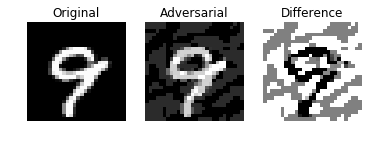

In [9]:
import foolbox
import keras
import numpy as np
from random import randint

num = randint(0, len(x_test))
keras.backend.set_learning_phase(0)
fmodel = foolbox.models.KerasModel(inference_model, bounds=(0, 1))
image, label = x_test[num], np.argmax(y_test[num])
print(label)

attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(image, label)
# if the attack fails, adversarial will be None and a warning will be printed

plot_attack(image, adversarial)

## IBM-ART Exemple
https://github.com/IBM/adversarial-robustness-toolbox

In [10]:
import sys
from os.path import abspath

from art.attacks.fast_gradient import FastGradientMethod
from art.classifiers import KerasClassifier
from art.utils import load_dataset

Test loss: 6.104571129608154
Test accuracy: 0.0722
0.30000004


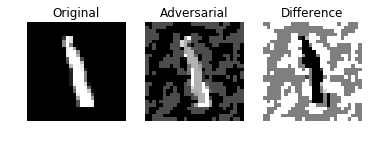

In [11]:
min_, max_ = 0, 1

classifier = KerasClassifier((min_, max_), model=inference_model)

# Craft adversarial samples with FGSM
epsilon = .3  # Maximum perturbation
adv_crafter = FastGradientMethod(classifier)
x_test_adv = adv_crafter.generate(x=x_test, eps=epsilon)

# Evaluate the classifier on the adversarial examples

score = inference_model.evaluate(x_test_adv, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

num = randint(0, len(x_test_adv))
image, adversarial = x_test[num], x_test_adv[num]
plot_attack(image, adversarial)